In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

In [8]:
# Define file paths
users_file = 'Users.csv'
books_file = 'Books.csv'
ratings_file = 'Ratings.csv'

# Load datasets
try:
    users = pd.read_csv(users_file, encoding='latin-1')
    
    # E: Avoid DtypeWarning by specifying 'Year-Of-Publication' as string on load
    books = pd.read_csv(
        books_file, 
        encoding='latin-1', 
        dtype={'Year-Of-Publication': str},  # This prevents the mixed-type warning
        on_bad_lines='skip'
    )
    
    ratings = pd.read_csv(ratings_file, encoding='latin-1')
    
except FileNotFoundError:
    print("Error: Ensure 'Users.csv', 'Books.csv', and 'Ratings.csv' are in the same directory.")
    
print("Datasets loaded successfully.")

Datasets loaded successfully.


In [9]:
# --- 1. Display the shape of the datasets ---
print("--- 1. Shapes of Datasets ---")
print(f"Users shape:   {users.shape}")
print(f"Books shape:   {books.shape}")
print(f"Ratings shape: {ratings.shape}")
print("-" * 30)

# --- 2. & 3. Display total nulls and detect null cols ---
print("\n--- 2 & 3. Null Values per Column ---")
print("Books Nulls:\n", books.isnull().sum())
print("\nUsers Nulls:\n", users.isnull().sum())
print("\nRatings Nulls:\n", ratings.isnull().sum())
print("-" * 30)

# --- 4. Create the comparison dataset ---
# Merge ratings with books for a combined view
print("\n--- 4. Creating Merged Dataset ---")
ratings_with_books = ratings.merge(books, on='ISBN')
print(f"Shape of merged 'ratings_with_books': {ratings_with_books.shape}")
print("-" * 30)

# --- 5. Display information about dataset ---
print("\n--- 5. Info for 'ratings_with_books' ---")
ratings_with_books.info()
print("-" * 30)

# --- 6. Display number of unique values ---
print("\n--- 6. Unique Values in 'ratings_with_books' ---")
print(ratings_with_books.nunique())
print("-" * 30)

# --- 7. Display the data types ---
print("\n--- 7. Data Types of 'ratings_with_books' ---")
print(ratings_with_books.dtypes)
print("-" * 30)

--- 1. Shapes of Datasets ---
Users shape:   (278858, 3)
Books shape:   (271360, 8)
Ratings shape: (1149780, 3)
------------------------------

--- 2 & 3. Null Values per Column ---
Books Nulls:
 ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Users Nulls:
 User-ID          0
Location         0
Age         110762
dtype: int64

Ratings Nulls:
 User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
------------------------------

--- 4. Creating Merged Dataset ---
Shape of merged 'ratings_with_books': (1031136, 10)
------------------------------

--- 5. Info for 'ratings_with_books' ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   User-ID      

In [10]:
# --- Preprocessing 'Books' Dataset ---

# C: Drop unnecessary image URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

# B: Clean 'Year-Of-Publication'
# Convert to numeric, forcing errors (like strings) to NaN
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

# B: Filter out rows with invalid or NaN years instead of filling them
# Keep only books published in a reasonable range (e.g., 1900-2025)
books = books[
    (books['Year-Of-Publication'] >= 1900) &
    (books['Year-Of-Publication'] <= 2025)
]

# Fill the few remaining NaN values in text columns
books['Book-Author'].fillna('Unknown', inplace=True)
books['Publisher'].fillna('Unknown', inplace=True)


# --- Preprocessing 'Users' Dataset ---
# A: Drop the 'Age' column
# The 'Age' column has too many (over 39%) null values to be reliable
users.drop('Age', axis=1, inplace=True)


# --- Preprocessing 'Ratings' Dataset ---
# We only want explicit ratings (1-10) for this model, not implicit (0)
explicit_ratings = ratings[ratings['Book-Rating'] != 0]

print("Preprocessing complete.")
print(f"Books shape after cleaning: {books.shape}")
print(f"Users shape after cleaning: {users.shape}")
print(f"Explicit ratings shape: {explicit_ratings.shape}")

Preprocessing complete.
Books shape after cleaning: (266723, 5)
Users shape after cleaning: (278858, 2)
Explicit ratings shape: (433671, 3)


/var/folders/ns/_0sgx1_x6qxbc8vqhm9q919w0000gn/T/ipykernel_32682/316589046.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books['Book-Author'].fillna('Unknown', inplace=True)
/var/folders/ns/_0sgx1_x6qxbc8vqhm9q919w0000gn/T/ipykernel_32682/316589046.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

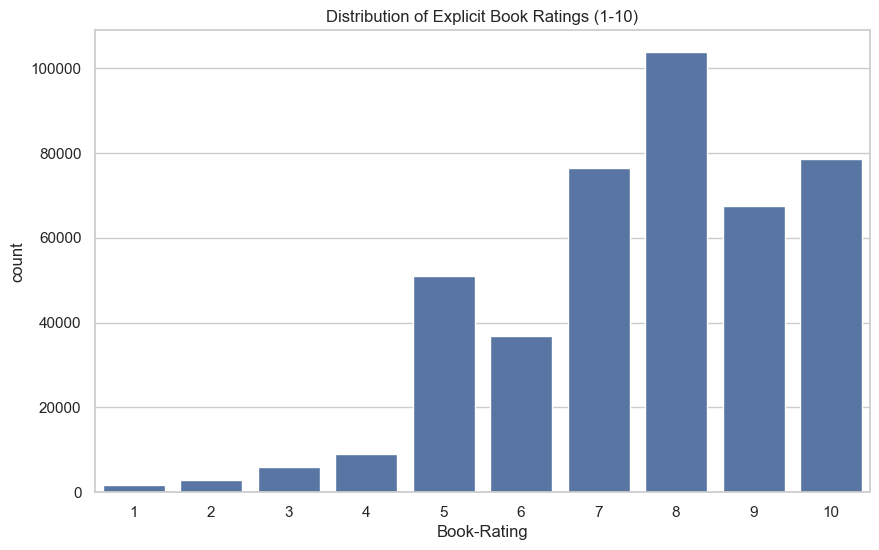

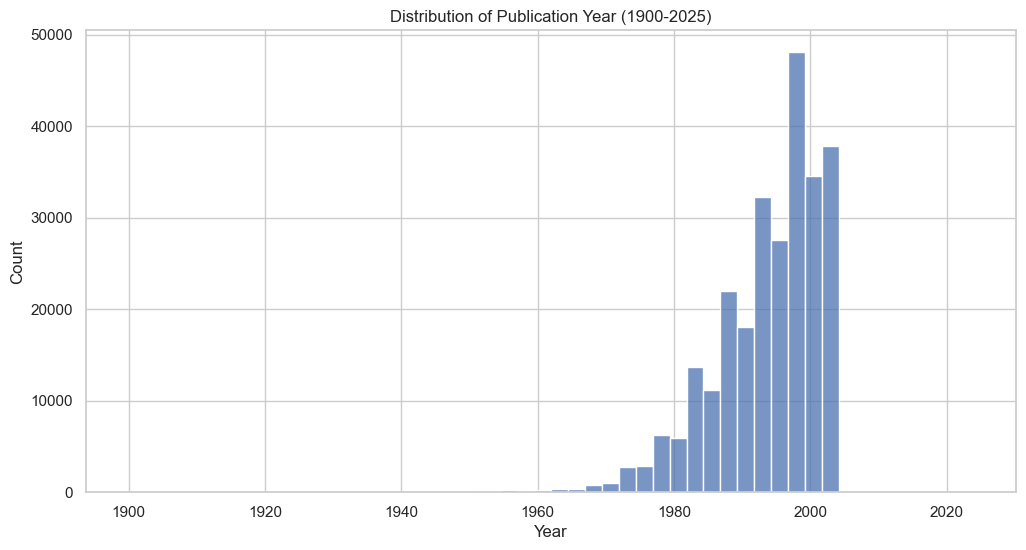

In [11]:
# --- 1. Examine Data Characteristics & Distributions ---

# 1.1 Distribution of Explicit Book Ratings (1-10)
plt.figure(figsize=(10, 6))
sns.countplot(x='Book-Rating', data=explicit_ratings)
plt.title('Distribution of Explicit Book Ratings (1-10)')
plt.show()

# 1.2 Distribution of Publication Year (Post-Cleaning)
plt.figure(figsize=(12, 6))
# We can now safely plot the cleaned numeric column
sns.histplot(books['Year-Of-Publication'], bins=50, kde=False)
plt.title('Distribution of Publication Year (1900-2025)')
plt.xlabel('Year')
plt.show()

In [12]:
# --- Create Final Dataset by Reducing Sparsity ---
# To build a reliable model, we filter for active users and popular books

# Merge cleaned dataframes
final_df = explicit_ratings.merge(books, on='ISBN')

# Get counts of ratings per book and per user
book_rating_counts = final_df['Book-Title'].value_counts()
user_rating_counts = final_df['User-ID'].value_counts()

# --- D: Sparsity Thresholds ---
# Set thresholds to filter out "noisy" data
# We use higher thresholds (like in the reference file) for a more robust model
MIN_BOOK_RATINGS = 100  # Keep books with at least 100 ratings
MIN_USER_RATINGS = 50   # Keep users who have given at least 50 ratings
# --- End of Thresholds ---

# Filter books and users based on the thresholds
popular_books = book_rating_counts[book_rating_counts >= MIN_BOOK_RATINGS].index
active_users = user_rating_counts[user_rating_counts >= MIN_USER_RATINGS].index

# Create the final filtered dataframe
# E: Use .copy() to explicitly create a new DataFrame and avoid SettingWithCopyWarning
filtered_final_df = final_df[
    (final_df['Book-Title'].isin(popular_books)) &
    (final_df['User-ID'].isin(active_users))
].copy()

print(f"Original ratings: {len(final_df)}")
print(f"Filtered ratings for model: {len(filtered_final_df)}")
print(f"Unique users for model: {filtered_final_df['User-ID'].nunique()}")
print(f"Unique books for model: {filtered_final_df['Book-Title'].nunique()}")

# --- Feature Encoding ---
# Convert User-ID and ISBN to continuous integer indices for the model
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
book_enc = LabelEncoder()

# No warnings will be triggered here
filtered_final_df['user_encoded'] = user_enc.fit_transform(filtered_final_df['User-ID'])
filtered_final_df['book_encoded'] = book_enc.fit_transform(filtered_final_df['Book-Title'])

print("\nFinal data head with encoded features:")
print(filtered_final_df.head())

Original ratings: 378031
Filtered ratings for model: 9053
Unique users for model: 1063
Unique books for model: 198

Final data head with encoded features:
     User-ID        ISBN  Book-Rating  \
517   277427  0061009059            9   
528   277427  0316776963            8   
535   277427  0385424736            9   
536   277427  0385486804            9   
538   277427  0385504209            8   

                                            Book-Title      Book-Author  \
517  One for the Money (Stephanie Plum Novels (Pape...  Janet Evanovich   
528                             Me Talk Pretty One Day    David Sedaris   
535                                      The Rainmaker     John Grisham   
536                                      Into the Wild     Jon Krakauer   
538                                  The Da Vinci Code        Dan Brown   

     Year-Of-Publication        Publisher  user_encoded  book_encoded  
517               1995.0      HarperTorch          1059            91  
528